In [1]:
import pickle
import matplotlib.pyplot as plt
from gensim import models, corpora
import pandas as pd
from collections import OrderedDict

In [2]:
with open('df_train.pickle', 'rb') as f:
    df_train = pickle.load(f)

with open('df_test.pickle', 'rb') as f:
    df_test = pickle.load(f)

### LDA with 4 topics

In [34]:
num_topics = 4

dictionary = corpora.Dictionary(df_train['instructions'])
corpus = [dictionary.doc2bow(text) for text in df_train['instructions']]

lda_model5 = models.LdaModel(corpus=corpus, 
                            num_topics=num_topics, 
                            alpha = [.01]*num_topics,
                            iterations = 100,
                            passes = 10,
                            id2word=dictionary)

In [35]:
#lda_model5.save('lda_model_10p4t_full_training.gensim')

In [4]:
## load LDA model
lda_model = models.LdaModel.load('lda_model_10p4t_full_training.gensim')
dictionary = corpora.Dictionary.load('lda_10p4t_full_training_dictionary')

### plot max weight distribution

In [ ]:
recipes_max_weight = []
for i in df['instructions']:
    bow = dictionary.doc2bow(i)
    weights = lda_model[bow]
    max_weight = sorted(weights, key=lambda x: x[1])[-1:][0][1]
    recipes_max_weight.append(max_weight)

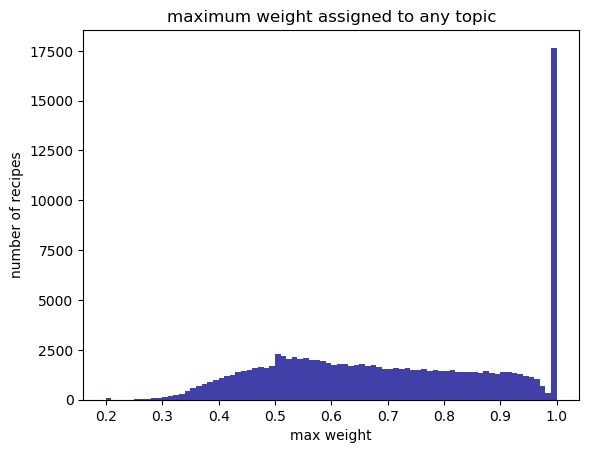

In [408]:
n, bins, patches = plt.hist(recipes_max_weight, 80, facecolor='darkblue', alpha=0.75)
plt.xlabel("max weight")
plt.ylabel("number of recipes")
plt.title("maximum weight assigned to any topic")
#plt.show()
plt.savefig('weight.png', dpi=800)

## Evaluate effectiveness of the model in determining valid substitutions

### w2v model based on all data

In [273]:
full_model = models.Word2Vec(size=200,
                               window=20,
                               min_count=20,
                               workers=6,
                               sample = 1e-4,
                               sg = 1)
full_model.build_vocab(df_train['ingredients'])
full_model.train(df_train['ingredients'],
            total_examples=model.corpus_count, 
            epochs=100)

(26476096, 121415700)

In [278]:
## see annotations below, under Recipes trained on a single topic

val_list = []
for recipe_name in recipe_names:
    row = test.loc[test['names'] == recipe_name]
    ingr_list = row['ingredients'].iloc[0]
    staples_in = [i for i in ingr_list if i in list(df_staples['AbbrvName'])]
    staples_in = list(OrderedDict.fromkeys(staples_in))
    model = full_model
    replacements = []
    for staple in staples_in:
        try:
            similar_foods = model.wv.most_similar(staple, topn = 6)
        except KeyError:
            continue

        similar_staples = [(i[0],round(i[1], 3)) for i in similar_foods if i[0] in list(df_staples['AbbrvName'])]
        staple_group = list(df_staples.loc[df_staples['AbbrvName'] == staple]['Group'])[0]
        if similar_staples:
            replacement_group = list(df_staples.loc[df_staples['AbbrvName'] == similar_staples[0][0]]['Group'])[0]
            val_list.append((staple_group == replacement_group, staple_group))
        else:
            continue      

In [279]:
for group in df_staples['Group'].unique():
    results = [x[0] for x in val_list if x[1] == group]
    print(group, np.mean(results))

p 0.6322188449848024
v 0.9058441558441559
s 0.5114754098360655
g 0.03225806451612903
f 0.5564516129032258
o 0.0
l 0.046511627906976744


### recipes assigned to a single topic

In [6]:
recipes_topics = []
recipes_max_weight = []
for i in df_recipes['instructions']:
    bow = dictionary.doc2bow(i)
    weights = lda_model[bow]
    t_w = sorted(weights, key=lambda x: x[1])[-1:][0]
    recipes_topics.append(t_w[0])
    recipes_max_weight.append(t_w[1])

df_train['topic'] = recipes_topics
df_train['max_weight'] = recipes_max_weight

In [8]:
## restrict to recipes with majority of weight assigned to 1 topic

df_train2 = df_train.loc[df['weight'] > .5]

In [22]:
##train word2vec with 1 topic per recipe
def model_n_save(df_topic):
    model = models.Word2Vec(
        size=200,
        window=20,
        min_count=20,
        workers=6,
        sample = 5e-5,
        sg = 1)
    model.build_vocab(df_topic['ingredients'])
    model.train(df_topic['ingredients'], 
                total_examples=model.corpus_count, 
                epochs=100)
    return model

by_topic = df_train2.groupby('topic')
w2v_models_single = by_topic.apply(model_n_save)


In [17]:
df_set = df_train2

val_list = []
for recipe_name in recipe_names:
    row = df_set.loc[df_set['names'] == recipe_name]
    ingr_list = row['ingredients'].iloc[0]
    
    ## reduce ingredient lists to staples for comparison
    staples_in = [i for i in ingr_list if i in list(df_staples['AbbrvName'])]
    staples_in = list(OrderedDict.fromkeys(staples_in))
    
    ## apply LDA for topic assignment
    bow = dictionary.doc2bow(ingr_list)
    topic = sorted(lda_model[bow], key=lambda x: x[1])[-1:][0][0]
    
    ## select word2vec model for designated topic
    model = w2v_models_single[topic]
    
    replacements = []
    for staple in staples_in:
        try:
            
            ## get most similar foods to given staple
            similar_foods = model.wv.most_similar(staple, topn = 6)
            
        ## in case staple is not in corpus for that model  
        except KeyError:
            continue
        
        ## exclude non-staples suggestions
        similar_staples = [(i[0],round(i[1], 3)) for i in similar_foods if i[0] in list(df_staples['AbbrvName'])]
        
        ## determine if staple and suggestion categories match and output
        staple_group = df_staples.loc[df_staples['AbbrvName'] == staple]['Group'].iloc[0]
        if similar_staples:
            replacement_group = list(df_staples.loc[df_staples['AbbrvName'] == similar_staples[0][0]]['Group'])[0]
            val_list.append((staple_group == replacement_group, staple_group, topic))
        else:
            continue    

In [20]:
## print accuracy for each category of food
for group in df_staples['Group'].unique():
    results = [x[0] for x in val_list if x[1] == group]
    print(group, np.mean(results))

p 0.8392282958199357
v 0.6601307189542484
s 0.39933993399339934
g 0.20689655172413793
f 0.45901639344262296
o 0.0
l 0.18604651162790697


In [400]:
for topic in range(4):
    subset = [x for x in val_list if x[2] == topic]
    for group in df_staples['Group'].unique():
        results = [x[0] for x in subset if x[1] == group]
        print(group, np.mean(results), '\n')

p 0.8513513513513513
v 0.6153846153846154
s 0.5978260869565217
g nan
f 0.23333333333333334
o 0.0
l 0.0
p 0.8378378378378378
v 0.7487179487179487
s 0.3046875
g 1.0
f 0.21875
o 0.0
l 0.0
p 0.8264462809917356
v 0.5
s 0.6612903225806451
g 0.625
f 0.8333333333333334
o 0.0
l 0.8888888888888888
p 0.4
v 0.0
s 0.42105263157894735
g nan
f 0.6785714285714286
o 0.0
l 0.0
p nan
v nan
s nan
g nan
f 1.0
o nan
l nan
